<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°08

**Objetivo**: Aplicar técnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables numéricas y categóricas.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila información sobre diversas características relevantes de distintos vehículos. El propósito de este ejercicio es **clasificar los vehículos en diferentes categorías**, utilizando como base las variables descritas en la tabla de atributos.

El análisis presenta un desafío adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **numéricas** (ej. dimensiones, consumo, emisiones) como **categóricas** (ej. tipo de tracción, tipo de combustible), lo que requiere aplicar técnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las características que servirán como base para la posterior clasificación.




**Descripción de los Datos:**

| **Nombre de la Columna**   | **Descripción**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El año en que el vehículo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volumétrica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revolución.       |
| **cilindros**               | El número de cilindros que tiene el motor. Los cilindros son las cámaras donde ocurre la combustión interna en los motores de los vehículos.       |
| **co2**                     | Emisiones de dióxido de carbono del vehículo, medido en gramos por kilómetro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de vehículo, como vehículos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracción del vehículo, ya sea tracción en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisión del vehículo, como automática, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el vehículo, como gasolina, diésel, eléctrico, híbrido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificación del tamaño del motor (por ejemplo, pequeño, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificación del nivel de consumo de combustible del vehículo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificación de las emisiones de CO2 del vehículo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del vehículo, medido en litros por milla. Indica la eficiencia del vehículo en términos de consumo de combustible.        |



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

,year,desplazamiento,cilindros,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,1984,2.5,4.0,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,1984,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,1985,2.5,4.0,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,1985,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,1987,3.8,6.0,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


En este caso, no solo se tienen datos numéricos, sino que también categóricos. Además, tenemos problemas de datos **vacíos (Nan)**. Así que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables numéricas, además, para cada dato vacía, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categóricas , además, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificación de variables numéricas a categóricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

In [6]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

print("Variables numéricas:", list(num_cols))
print("Variables categóricas:", list(cat_cols))

from sklearn.preprocessing import MinMaxScaler

df_num = df[num_cols].copy()

df_num = df_num.fillna(df_num.mean())

# Normalizamos
scaler = MinMaxScaler()
df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=num_cols)

df_num_scaled.head()


df_cat = df[cat_cols].copy()

# Codificamos la variables numéricas (One-Hot Encoding)
df_cat_encoded = pd.get_dummies(df_cat, drop_first=True)

df_cat_encoded.head()


# Combinamos ambos DataFrames
df_procesado = pd.concat([df_num_scaled, df_cat_encoded], axis=1)

print("Dimensiones del dataset procesado:", df_procesado.shape)
df_procesado.head()

Variables numéricas: ['year', 'desplazamiento', 'cilindros', 'co2', 'consumo_litros_milla']
Variables categóricas: ['clase_tipo', 'traccion_tipo', 'transmision_tipo', 'combustible_tipo', 'tamano_motor_tipo', 'consumo_tipo', 'co2_tipo']
Dimensiones del dataset procesado: (36791, 29)


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,clase_tipo_Deportivos,...,tamano_motor_tipo_muy pequeño,tamano_motor_tipo_pequeño,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.000000,0.243590,0.142857,0.398014,0.331027,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,0.000000,0.461538,0.285714,0.527672,0.475113,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
2,0.029412,0.243590,0.142857,0.424351,0.360294,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,0.029412,0.461538,0.285714,0.527672,0.475113,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
4,0.088235,0.410256,0.285714,0.424351,0.360294,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables numérica
    * Moda para las variables numericas

In [13]:
from sklearn.cluster import KMeans
from scipy import stats

#Entrenamos modelo con 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(df_procesado)

df['cluster'] = kmeans.labels_

centroides = pd.DataFrame(kmeans.cluster_centers_, columns=df_procesado.columns)

print("Centroides de cada cluster:")
display(centroides)

resumen_numerico = df.groupby('cluster')[num_cols].mean()

print("Promedios de variables numéricas por cluster:")
display(resumen_numerico)

resumen_categorico = df.groupby('cluster')[cat_cols].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

print("Moda de variables categóricas por cluster:")
display(resumen_categorico)

# Combinamos resumen final
resumen_clusters = pd.concat([resumen_numerico, resumen_categorico], axis=1)
print("Resumen general de las características de cada cluster:")
display(resumen_clusters)

Centroides de cada cluster:


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,clase_tipo_Deportivos,...,tamano_motor_tipo_muy pequeño,tamano_motor_tipo_pequeño,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.479569,0.450555,0.325965,0.404752,0.335839,0.023883,0.048796,0.061767,0.123945,0.247684,...,6.794317e-03,0.050237,3.047148e-02,4.097179e-02,1.235330e-03,2.532427e-02,1.667696e-02,3.685403e-02,2.264772e-03,4.735433e-03
1,0.582925,0.361428,0.299330,0.355229,0.283377,0.081798,0.084254,0.185212,0.570621,0.070744,...,4.912798e-02,0.159912,2.775731e-02,9.496438e-01,1.376677e-14,7.369197e-04,7.494005e-16,9.555392e-01,-1.104672e-14,-1.654232e-14
2,0.795182,0.180480,0.157958,0.239389,0.155183,0.074053,0.020350,0.115885,0.714528,0.072357,...,8.140192e-01,0.070096,-2.442491e-15,5.652911e-04,1.887379e-15,9.994347e-01,4.522329e-02,-4.662937e-15,-8.326673e-17,9.547767e-01
3,0.361956,0.501749,0.359717,0.496465,0.440472,0.002358,0.009094,0.013136,0.021556,0.202762,...,1.347255e-03,0.017851,-1.007527e-14,1.204592e-14,9.976423e-01,-6.272760e-15,7.494005e-16,-9.270362e-15,1.000000e+00,-1.329492e-14
4,0.503185,0.166417,0.142465,0.242108,0.157569,0.130397,0.016848,0.145841,0.601615,0.083714,...,7.311337e-01,0.260969,-1.545986e-14,-1.315614e-14,1.357248e-14,9.984205e-01,4.212004e-03,3.510004e-04,-1.096345e-14,9.938575e-01
5,0.450178,0.628509,0.462961,0.513979,0.455688,0.004786,0.054319,0.056473,0.223977,0.124910,...,-1.199041e-14,0.001675,-1.335043e-14,1.555396e-02,9.121799e-01,-6.494805e-15,7.494005e-16,-1.121325e-14,9.983250e-01,-1.676437e-14
6,0.521699,0.249676,0.194524,0.304652,0.227134,0.094744,0.045643,0.152006,0.452282,0.142462,...,2.912863e-01,0.381881,9.904564e-01,-2.575717e-14,-8.548717e-15,9.543568e-03,9.951591e-01,4.287690e-03,6.800116e-15,5.532503e-04
7,0.409018,0.330589,0.256466,0.354500,0.282657,0.082752,0.089897,0.132436,0.186108,0.172649,...,4.918578e-02,0.220339,1.096710e-02,9.887006e-01,8.021361e-15,3.323363e-04,-1.648681e-14,9.996677e-01,-6.494805e-15,-2.137179e-15


Promedios de variables numéricas por cluster:


,year,desplazamiento,cilindros,co2,consumo_litros_milla
cluster,,,,,
0,2000.305333,4.114330,6.563517,531.124186,0.224960
1,2003.819455,3.419135,6.190617,469.687476,0.200013
2,2011.036179,2.007744,4.211419,325.979026,0.139056
3,1996.306501,4.513641,7.036039,644.900258,0.274713
4,2001.108284,1.897806,3.994207,329.352569,0.140191
5,1999.306054,5.502369,8.481455,666.627497,0.281949
6,2001.737759,2.547365,4.723198,406.942246,0.173269
7,1997.906613,3.178598,5.590494,468.783033,0.199671


Moda de variables categóricas por cluster:


,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo
cluster,,,,,,,
0,Camionetas,dos,Automatica,Normal,grande,alto,alto
1,Coches pequeños,dos,Automatica,Premium,mediano,moderado,moderado
2,Coches pequeños,dos,Automatica,Premium,muy pequeño,muy bajo,muy bajo
3,Camionetas,cuatro,Automatica,Normal,grande,muy alto,muy alto
4,Coches pequeños,dos,Manual,Normal,muy pequeño,muy bajo,muy bajo
5,Camionetas,dos,Automatica,Normal,muy grande,muy alto,muy alto
6,Coches pequeños,dos,Automatica,Normal,pequeño,bajo,bajo
7,Coches pequeños,dos,Automatica,Normal,mediano,moderado,moderado


Resumen general de las características de cada cluster:


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo
cluster,,,,,,,,,,,,
0,2000.305333,4.114330,6.563517,531.124186,0.224960,Camionetas,dos,Automatica,Normal,grande,alto,alto
1,2003.819455,3.419135,6.190617,469.687476,0.200013,Coches pequeños,dos,Automatica,Premium,mediano,moderado,moderado
2,2011.036179,2.007744,4.211419,325.979026,0.139056,Coches pequeños,dos,Automatica,Premium,muy pequeño,muy bajo,muy bajo
3,1996.306501,4.513641,7.036039,644.900258,0.274713,Camionetas,cuatro,Automatica,Normal,grande,muy alto,muy alto
4,2001.108284,1.897806,3.994207,329.352569,0.140191,Coches pequeños,dos,Manual,Normal,muy pequeño,muy bajo,muy bajo
5,1999.306054,5.502369,8.481455,666.627497,0.281949,Camionetas,dos,Automatica,Normal,muy grande,muy alto,muy alto
6,2001.737759,2.547365,4.723198,406.942246,0.173269,Coches pequeños,dos,Automatica,Normal,pequeño,bajo,bajo
7,1997.906613,3.178598,5.590494,468.783033,0.199671,Coches pequeños,dos,Automatica,Normal,mediano,moderado,moderado


### 3.- Elegir Número de cluster

Estime mediante la **regla del codo**, el número de cluster apropiados para el caso.
Para efectos prácticos, eliga la siguiente secuencia como número de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gráfico, saque sus propias conclusiones del caso.

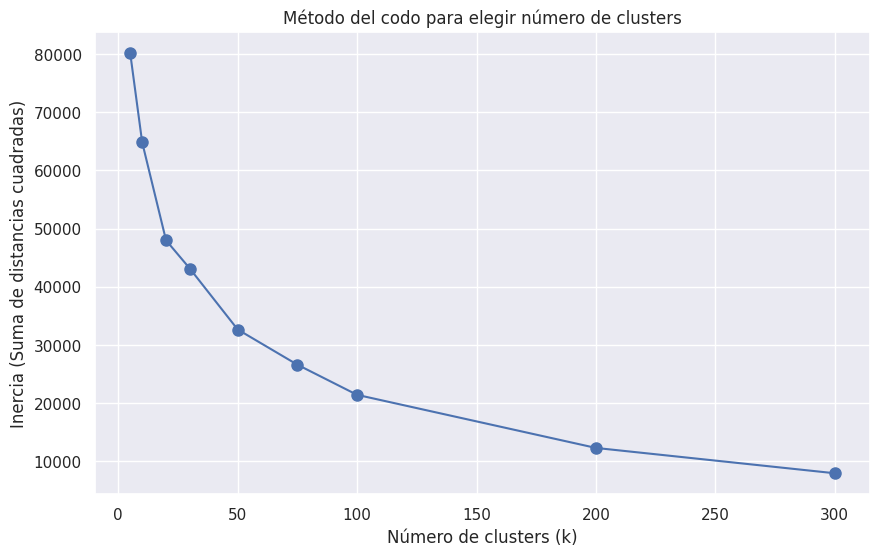

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Secuencia de números de clusters a comparar
K_values = [5, 10, 20, 30, 50, 75, 100, 200, 300]
inertia_values = []

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_procesado)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(K_values, inertia_values, 'bo-', markersize=8)
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Suma de distancias cuadradas)")
plt.title("Método del codo para elegir número de clusters")
plt.grid(True)
plt.show()

Al observar el gráfico resultante, se pueden obtener conclusiones sobre el número apropiado de clusters. La regla del codo sugiere elegir el número de clusters donde la reducción en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gráfico donde la curva de inercia comienza a aplanarse o forma un codo.

## Reducción de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos clásico disponible en la librería **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene información de **178 muestras de vino** provenientes de la región italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que actúan como etiquetas para el análisis supervisado, pero aquí se usarán solo como referencia en la visualización.

Cada muestra está descrita por **13 variables químicas** obtenidas de un análisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentración de ácido málico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentración total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relación de absorbancia que mide la calidad del vino.
* **Proline**: concentración de prolina (un aminoácido).

Estas características permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del análisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparación entre ambas técnicas permitirá observar cómo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducción de dimensionalidad en datos con mayor número de variables que en el caso del dataset *Wine*.



In [15]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [16]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0




### 1. **Análisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gráfico de varianza acumulada, identificando cuántos componentes son necesarios para capturar al menos el **90–95% de la información**.
* Construir tablas y gráficos que muestren cómo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qué características químicas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



PC1: 0.362 (0.362 acumulada)
PC2: 0.192 (0.554 acumulada)
PC3: 0.111 (0.665 acumulada)
PC4: 0.071 (0.736 acumulada)
PC5: 0.066 (0.802 acumulada)
PC6: 0.049 (0.851 acumulada)
PC7: 0.042 (0.893 acumulada)
PC8: 0.027 (0.920 acumulada)
PC9: 0.022 (0.942 acumulada)
PC10: 0.019 (0.962 acumulada)
PC11: 0.017 (0.979 acumulada)
PC12: 0.013 (0.992 acumulada)
PC13: 0.008 (1.000 acumulada)


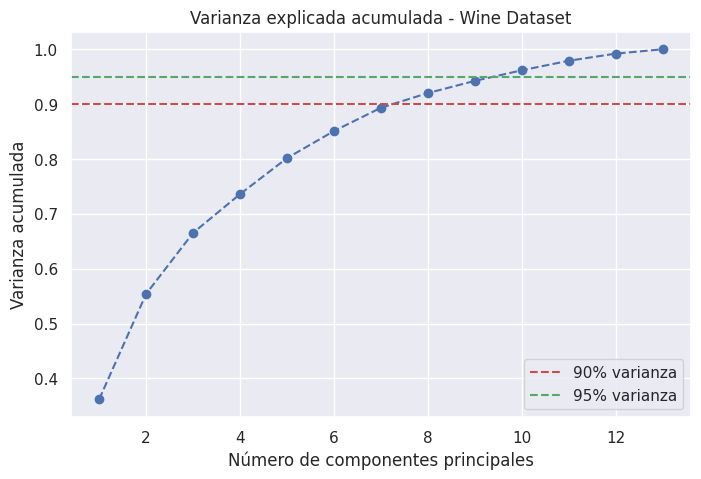

Loadings (coeficientes de cada variable en cada componente):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
alcohol,0.144329,0.483652,-0.207383,-0.017856,-0.265664,0.213539,-0.056396,0.396139,-0.508619,0.211605,-0.225917,-0.266286,0.014970
malic_acid,-0.245188,0.224931,0.089013,0.536890,0.035214,0.536814,0.420524,0.065827,0.075283,-0.309080,0.076486,0.121696,0.025964
ash,-0.002051,0.316069,0.626224,-0.214176,-0.143025,0.154475,-0.149171,-0.170260,0.307694,-0.027125,-0.498691,-0.049622,-0.141218
alcalinity_of_ash,-0.239320,-0.010591,0.612080,0.060859,0.066103,-0.100825,-0.286969,0.427970,-0.200449,0.052799,0.479314,-0.055743,0.091683
magnesium,0.141992,0.299634,0.130757,-0.351797,0.727049,0.038144,0.322883,-0.156361,-0.271403,0.067870,0.071289,0.062220,0.056774
total_phenols,0.394661,0.065040,0.146179,0.198068,-0.149318,-0.084122,-0.027925,-0.405934,-0.286035,-0.320131,0.304341,-0.303882,-0.463908
flavanoids,0.422934,-0.003360,0.150682,0.152295,-0.109026,-0.018920,-0.060685,-0.187245,-0.049578,-0.163151,-0.025694,-0.042899,0.832257
nonflavanoid_phenols,-0.298533,0.028779,0.170368,-0.203301,-0.500703,-0.258594,0.595447,-0.233285,-0.195501,0.215535,0.116896,0.042352,0.114040
proanthocyanins,0.313429,0.039302,0.149454,0.399057,0.136860,-0.533795,0.372139,0.368227,0.209145,0.134184,-0.237363,-0.095553,-0.116917
color_intensity,-0.088617,0.529996,-0.137306,0.065926,-0.076437,-0.418644,-0.227712,-0.033797,-0.056218,-0.290775,0.031839,0.604222,-0.011993


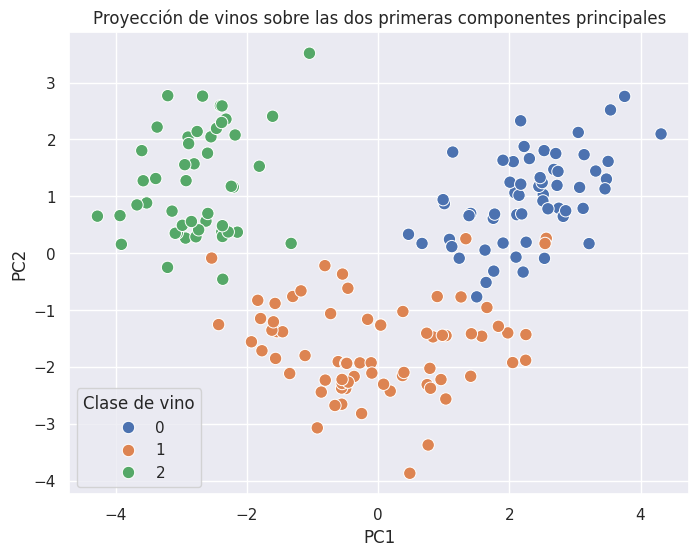

In [20]:
from sklearn.preprocessing import StandardScaler

X = wine.drop(columns='wine_class')
y = wine['wine_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_cum = np.cumsum(explained_variance)


for i, var in enumerate(explained_variance, start=1):
    print(f"PC{i}: {var:.3f} ({explained_variance_cum[i-1]:.3f} acumulada)")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance_cum, marker='o', linestyle='--')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada')
plt.title('Varianza explicada acumulada - Wine Dataset')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% varianza')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% varianza')
plt.legend()
plt.grid(True)
plt.show()

loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(X.shape[1])])
print("Loadings (coeficientes de cada variable en cada componente):")
display(loadings)


import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="deep", s=80)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección de vinos sobre las dos primeras componentes principales')
plt.legend(title='Clase de vino')
plt.show()





### 2. **Análisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperparámetros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir cómo los hiperparámetros afectan la estructura de los clústeres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



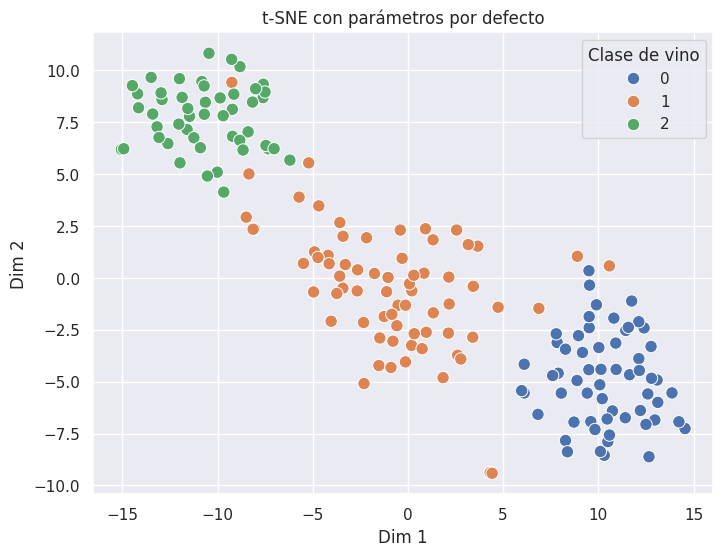

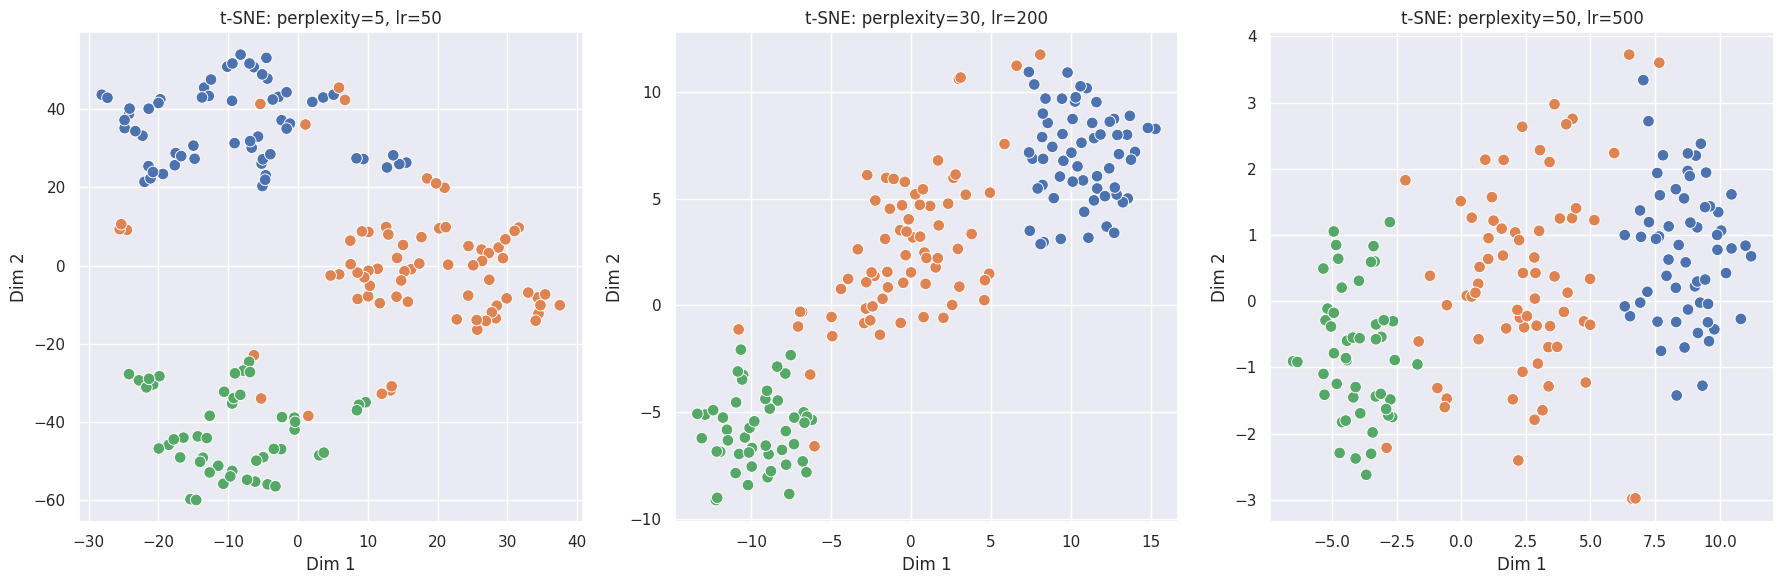

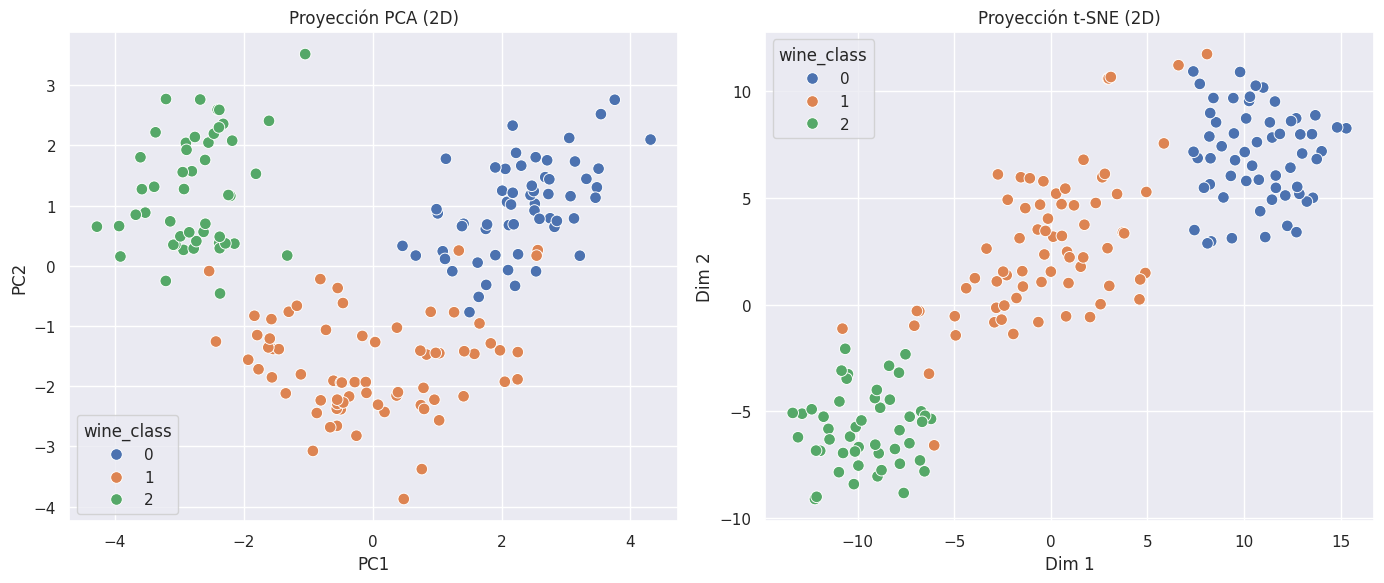

In [21]:
from sklearn.manifold import TSNE

X_tsne_default = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne_default[:,0], y=X_tsne_default[:,1], hue=y, palette="deep", s=80)
plt.title("t-SNE con parámetros por defecto")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Clase de vino")
plt.show()

params = [
    {"perplexity": 5, "learning_rate": 50},
    {"perplexity": 30, "learning_rate": 200},
    {"perplexity": 50, "learning_rate": 500}
]

fig, axes = plt.subplots(1, 3, figsize=(18,6))

for i, p in enumerate(params):
    tsne = TSNE(n_components=2, perplexity=p["perplexity"], learning_rate=p["learning_rate"], random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    sns.scatterplot(
        x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette="deep", s=70, ax=axes[i], legend=False
    )
    axes[i].set_title(f"t-SNE: perplexity={p['perplexity']}, lr={p['learning_rate']}")
    axes[i].set_xlabel("Dim 1")
    axes[i].set_ylabel("Dim 2")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(14,6))

# PCA 2D
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="deep", s=70, ax=ax[0])
ax[0].set_title("Proyección PCA (2D)")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

tsne_best = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne_best = tsne_best.fit_transform(X_scaled)
sns.scatterplot(x=X_tsne_best[:,0], y=X_tsne_best[:,1], hue=y, palette="deep", s=70, ax=ax[1])
ax[1].set_title("Proyección t-SNE (2D)")
ax[1].set_xlabel("Dim 1")
ax[1].set_ylabel("Dim 2")

plt.tight_layout()
plt.show()




### 3. **Comparación entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada técnica:

  * PCA como método **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como método **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qué escenarios prácticos sería más recomendable usar PCA (interpretabilidad, reducción previa para modelos) o t-SNE (exploración y visualización de clústeres).
* Reflexionar sobre la **importancia de la reducción de dimensionalidad** en datasets de alta dimensión como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje automático.
  * Facilitar la interpretación y comunicación de resultados.



El PCA (Principal Component Analysis) es una técnica lineal que transforma las variables originales en combinaciones lineales llamadas componentes principales.
Cada componente explica una proporción de la **varianza total** del conjunto de datos. Permite identificar qué variables contribuyen más a la variabilidad del dataset.

Algunas de sus ventajas son la alta interpretabilidad y el bajo costo computacional. Una de sus principales limitaciones es que solo capta relaciones lineales entre variables.

El t-SNE (t-distributed Stochastic Neighbor Embedding) es un método no lineal de reducción de dimensionalidad que busca preservar las relaciones de vecindad entre puntos (similitudes locales).

Algunas de sus ventajas es que capta estructuras no lineales en los datos y permite observar clústeres naturales que PCA podría no mostrar. Por otro lado, alguna de sus limitaciones que es difícil de interpretar (las dimensiones proyectadas no tienen significado directo) y posee un alto costo computacional en grandes volúmenes de datos.


Es recomendable usar PCA cuando se quiere interpretar la varianza de los datos, reducir ruido y simplificar los datos de alta dimensión.

Por otro lado, vamos a usar t-SNE para la visualización exploratoria de clústeres o relaciones no lineales, o cuando se busca entender cómo se agrupan los datos sin necesidad de interpretar los ejes.


La importancia de la reducción de dimensionalidad es que:
- Facilita la visualización de datos complejos (como el caso de 13 variables químicas del vino).
- Reduce la complejidad computacional y el ruido en los datos.
- Permite descubrir patrones ocultos y relaciones entre observaciones.


Más puntualmente, en el dataset Wine:
- PCA mostró una separación parcial entre clases basada en varianza global.
- t-SNE reveló fronteras más definidas entre las tres variedades, evidenciando **relaciones no lineales** entre las variables químicas.

Podemos concluir, que  ambas técnicas se complementan, PCA para entender la estructura de la información, t-SNE para visualizar los patrones subyacentes.